\noindent __Erwann Rault__  
_Centre Oscar Lambret (Lille)_

In [1]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook


In [2]:
# LIBRARIES #

import numpy as np
import dicom as dcm
import matplotlib.pyplot as plt
import math
import time
import datetime

from scipy import ndimage
from ipywidgets import *

from openpyxl import load_workbook
from openpyxl.styles import Font, Color, colors

from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from os.path import basename

import warnings
warnings.filterwarnings('ignore')


In [66]:
# INPUT VARIABLES #

# Dicom files:
FILEPATH = 'X:/Med Nuc/CQ TEP-CT/CQ SUV/CQ EARL 2017.04.27'

SERIES_UID = '1.2.840.113619.2.290.3.346820099.234.1493273540.672'

# Results written to:
EXCEL_FILE ='X:/Med Nuc/CQ TEP-CT/CQ TEP-CT.xlsx'
EXCEL_SHEET = 'CQ SUV'

# Injected activity:
ISOTOPE_NAME = "F18"
T1DEMI = 1.8295 # hours, half life from the isotope

Ainj = 82.5 #MBq
Tinj = datetime.datetime(2017,4,27,17,9)

Ares = 0.00 #MBq
Tres = datetime.datetime(2017,4,27,17,13)

# CSTES #
ROI_MARGIN = -7 #pix
PHANTOM_THRESHOLD = 0.7

# Acquisition information

In [67]:
# CONVERTS DICOM TIME INFO TO DATETIME #

def convertToDatetime(date, time):
    """
    Converts the time written in the DICOM tags to datetime format.
    Parameters:
      date - date
      time - time
    Return:
      datetime - date and time in datetime format
    """
    year = int(int(date)/10000)
    month = int(int(date)/100-year*100)
    day = int(int(date)-year*10000-month*100)
    hour = int(float(time)/10000)
    minute = int(float(time)/100-hour*100)
    seconds =  int(float(time)-minute*100-hour*10000)
    return datetime.datetime(year, month, day, hour, minute, seconds)

In [68]:
# READS THE DICOM FILE #


def readDicomFiles(filepath):
    """
    Reads the dicom files and returns an array containing the image,
    the dimension of the image, and the ref. dicom file to be able 
    to access dicom tags.
    Parameters:
      filepath - path to the folder containing the dicom files of the image
    Return:
      pixArray - array containing the image
      constPixDim - dimension of the image
      ds - reference dicom file
    """

    # Get the file list
    print "Imported Files :"
    listFilesDCM = []  # creates an empty list
    for dirName, subdirList, fileList in os.walk(filepath):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                listFilesDCM.append(os.path.join(dirName,filename))
                print "  > ", filename
    print " "
    
    # Get ref file
    ds = dcm.read_file(listFilesDCM[0])

    # Load dimensions:
    nb_pixel_x = int(ds.Rows)
    nb_pixel_y = int(ds.Columns)
    nb_slices = len(listFilesDCM)
    constPixDim = [nb_slices, nb_pixel_y, nb_pixel_x]
    pixArray = np.zeros(constPixDim, dtype=np.float32)
    
    # loop through all the DICOM files
    for filenameDCM in listFilesDCM:
        dstmp = dcm.read_file(filenameDCM)
        try:
            rescaleIntercept = ds[0x0028,0x1052].value
            rescaleSlope = ds[0x0028,0x1053].value
            pixArray[listFilesDCM.index(filenameDCM),:,:] = dstmp.pixel_array.astype(np.float32) * rescaleSlope + rescaleIntercept
        except KeyError:
            rescaleIntercept = 0
            rescaleSlope = 1

    return pixArray, constPixDim, ds

In [78]:
# READS ONE DICOM FILE FROM MULTIPLE SERIES #


def readOneDicomFile(filepath, seriesUID):
    """
    Reads the dicom files and returns an array containing the image
    corresponding to the seriesUID given as an argument, the dimension 
    of the image, and the ref. dicom file to be able to access dicom tags.
    Parameters:
      filepath - path to the folder containing the dicom files of the image
    Return:
      pixArray - array containing the image
      constPixDim - dimension of the image
      ds - reference dicom file
    """

    # Get the file list
    listFilesDCM = []  # creates an empty list
    for dirName, subdirList, fileList in os.walk(filepath):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                listFilesDCM.append(os.path.join(dirName,filename))

    # finds ref. img and load dimensions:
    firstSlice = 0
    nboffiles = len(listFilesDCM)
    dstmp = dcm.read_file(listFilesDCM[firstSlice])
    while ((dstmp.SeriesInstanceUID != seriesUID)and(firstSlice<nboffiles-1)):
        firstSlice = firstSlice+1
        dstmp = dcm.read_file(listFilesDCM[firstSlice])
    nb_pixel_x = int(dstmp.Rows)
    nb_pixel_y = int(dstmp.Columns)

    nb_slices = 0
    for i in range(firstSlice,len(listFilesDCM)):
        dstmp = dcm.read_file(listFilesDCM[i])
        if (dstmp.SeriesInstanceUID == seriesUID):
            nb_slices = nb_slices + 1

    constPixDim = [nb_slices, nb_pixel_y, nb_pixel_x]
    pixArray = np.zeros(constPixDim, dtype=np.float32)
    
    for i in range(firstSlice, firstSlice+nb_slices):
        dstmp = dcm.read_file(listFilesDCM[i])
        try:
            rescaleIntercept = dstmp[0x0028,0x1052].value
            rescaleSlope = dstmp[0x0028,0x1053].value
        except KeyError:
            rescaleIntercept = 0
            rescaleSlope = 1
        imgnb = dstmp[0x0020,0x0013].value
        pixArray[imgnb-1,:,:] = dstmp.pixel_array.astype(np.float32) * rescaleSlope + rescaleIntercept
    
    ds = dcm.read_file(listFilesDCM[firstSlice])
    
    return pixArray, constPixDim, ds

In [79]:
# GET RELEVANT INFORMATION FROM DICOM FILE #

def getAndPrintRelevantInfo(ds, arrayDim):
    """
    Get relevant information from the dicom image.
    Parameters:
      ds - dicom image
      arrayDim - image dimension
    Return:
      pixArray - array containing the image
      constPixDim - dimension of the image
      ds - reference dicom file
    """

    study_date = ds.StudyDate
    scan_time = ds[0x0008,0x0032].value
    acq_datetime = convertToDatetime(study_date,scan_time)

    recons_corrections = ds[0x0028,0x0051].value
    frame_duration = ds[0x0018,0x1242].value / 1000 #in ms
    phantVol = ds[0x0054,0x0016][0][0x0018,0x1071].value

    try:
        rescaleIntercept = ds[0x0028,0x1052].value
        rescaleSlope = ds[0x0028,0x1053].value
    except KeyError:
        rescaleIntercept = 0
        rescaleSlope = 1

    print "Patient name: ", ds.PatientName
    print "Patient ID: ", ds[0x0020,0x0010].value
    print "File path:",FILEPATH
    print " "
    print "Injected Isotope: ", ISOTOPE_NAME, "(half life:", T1DEMI,"h)"
    print "Radiopharmaceutical: ", ds[0x0054,0x0016][0][0x0018,0x0031].value
    print "Injected activity: ", Ainj, " MBq @ ", Tinj
    print "Residual activity: ", Ares, " MBq @ ", Tres
    print "Radionuclide volume", phantVol, "mL"
    print " "
    print "Scan date and time: ", acq_datetime
    print "Scan duration: ", frame_duration, "s"
    print "Image size: {0} x {1} x {2}" .\
                    format(arrayDim[2], arrayDim[1], arrayDim[0])
    print "Energy window: ", ds[0x0054,0x0013][0][0x0054,0x0014].value, "to", ds[0x0054,0x0013][0][0x0054,0x0015].value, "keV"
    print "Image units:", ds[0x0054,0x1001].value
    print "Reconstruction corrections:", recons_corrections
    print "Scatter correction method:", ds[0x0054,0x1105].value
    print "Dose calibration factor:", ds[0x0054,0x1322].value
    print "Scatter fraction factor:", ds[0x0054,0x1323].value
    print "Dead time factor:", ds[0x0054,0x1324].value
    print "Rescale slope:", rescaleSlope
    print "Rescale intercept:", rescaleIntercept
    print " "
    print "TEP system: ", ds[0x0008,0x0070].value
    print "            ", ds[0x0008,0x1010].value

    return acq_datetime, phantVol

In [80]:
if SERIES_UID == '' :
    pixArray, arrayDim, ds = readDicomFiles(FILEPATH)
    acqDateTime = getAndPrintRelevantInfo(ds, arrayDim)
else:
    pixArray, arrayDim, ds = readOneDicomFile(FILEPATH, SERIES_UID)
    acqDateTime, phantomVolume = getAndPrintRelevantInfo(ds, arrayDim)

Patient name:  zzzEARL-cal
Patient ID:  16147
File path: X:/Med Nuc/CQ TEP-CT/CQ SUV/CQ EARL 2017.04.27
 
Injected Isotope:  F18 (half life: 1.8295 h)
Radiopharmaceutical:  FDG -- fluorodeoxyglucose
Injected activity:  82.5  MBq @  2017-04-27 17:09:00
Residual activity:  0.0  MBq @  2017-04-27 17:13:00
Radionuclide volume 5640 mL
 
Scan date and time:  2017-04-27 17:43:29
Scan duration:  300 s
Image size: 256 x 256 x 83
Energy window:  425 to 650 keV
Image units: BQML
Reconstruction corrections: ['DECY', 'ATTN', 'SCAT', 'DTIM', 'RANSNG', 'DCAL', 'SLSENS', 'NORM']
Scatter correction method: Model Based
Dose calibration factor: 13271
Scatter fraction factor: 0.289118
Dead time factor: 1.04865
Rescale slope: 0.0230401
Rescale intercept: 0
 
TEP system:  GE MEDICAL SYSTEMS
             D690


# SUV calibration factor

In [81]:
# LAYOUT DEFINITIONS #

box_layout_std = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-start',
                    width='100%')

box_layout_right = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-end',
                    border='solid 0.5px #EEE',
                    width='100%')


In [82]:
# FINDS THE SUV PHANTOM IN THE IMAGE #

# function to find the phantom dimension and center in the image
def findPhantom(img, dimx, dimy, dimz, tp):
    com = ndimage.measurements.center_of_mass(img)
    #com = ndimage.measurements.maximum_position(img)

    maxx = ndimage.measurements.maximum(img[com[0],com[1],:])
    x1 = 0
    while (img[com[0],com[1],x1]<maxx*tp):
        x1 = x1+1
    x2 = dimx-1
    while (img[com[0],com[1],x2]<maxx*tp):
        x2 = x2-1
    x1=x1-1
    x2=x2+1
    
    maxy = ndimage.measurements.maximum(img[com[0],:,com[2]])
    y1 = 0
    while (img[com[0],y1,com[2]]<maxy*tp):
        y1 = y1+1
    y2 = dimy-1
    while (img[com[0],y2,com[2]]<maxy*tp):
        y2 = y2-1
    y1=y1-1
    y2=y2+1

    maxz = ndimage.measurements.maximum(img[:,com[1],com[2]])
    z1 = 0
    while (img[z1,com[1],com[2]]<maxz*tp):
        z1 = z1+1
    z2 = dimz-1
    while (img[z2,com[1],com[2]]<maxz*tp):
        z2 = z2-1
    z1=z1-1
    z2=z2+1
    
    centerx = int(x1+(x2-x1)/2)
    centery = int(y1+(y2-y1)/2)
    centerz = int(z1+(z2-z1)/2)
    
    if ((y2-y1)>(x2-1)):
        radius =(y2-y1)/2
    else:
        radius = (x2-x1)/2
    length = z2-z1

    return [centerx, centery, centerz, radius, length]


In [83]:
# FUNCTION TO GET THE STATS INSIDE THE VOI #

def get_stats(img, dimx, dimy, dimz, centerx, centery, centerz, r, h):
    l = []
    for k in range(int(centerz-h/2), int(centerz+h/2)):
        for j in range(0, dimy):
            for i in range(0, dimx):
                if (math.sqrt((i-centerx)*(i-centerx)+(j-centery)*(j-centery))<=r):
                    l.append(img[k,j,i])
                    #m_img[k,j,i] = 0

    return np.amin(l), np.amax(l), np.mean(l), np.std(l)

In [84]:
# FUNCTION TO DISPLAY CALC RESULTS #
    
def dispResults(pxls, dim, roi, marge, tacq):
    """
    Disp the results:
      pxls - pixel array of the images
      dim - dimension of the pixel array (dim[2]:x dim[1]:y dim[0]: nb of images)
      roi - ROI where the mean activity is calculated
      marge - margin applied to the auto-segmented roi
      tacq - acquisition date and time
    Return:
      Array of calculated values (activity conc. in the phantom, min, max and mean measured activities, std. dev. of 
          activity inside the phantom)
    """
    mini, maxi, mean, std = get_stats(pxls, dim[2], dim[1], dim[0] ,roi[0], 
                         roi[1], roi[2], roi[3]+marge, roi[4]+(2*marge))

    t = (tacq - Tinj).total_seconds()/3600.0
    A = Ainj * math.exp(-t*math.log(2)/T1DEMI)
    t = (tacq - Tres).total_seconds()/3600.0
    B = Ares * math.exp(-t*math.log(2)/T1DEMI)
    Aph = (A-B)/phantomVolume*1000000
    error = (mean-Aph)/Aph*100
    
    print 'Injected activity in the phantom: ', round(Aph,0), 'Bq/ml'
    print '   ' 
    print 'Measured values in the VOI:'
    print '  - min. activity: ', round(mini, 2), 'Bq/ml'
    print '  - max. activity: ', round(maxi, 2), 'Bq/ml'
    print '  - mean activity: ', round(mean, 2), 'Bq/ml'
    print '  - std deviation: ', round(std, 2), 'Bq/ml (', round(std/mean*100,2),'%)'
    print '   ' 
    if (abs(error)<10):
        print '  >>> Test succeeded! (error', round(error,2), '%)'
    else:
        print '  >>> Important discrepancies! (error', round(error,2), '%)'
        print '  >>> Calibration factor must be verified!'
    print '   ' 
    print '   ' 

    r = [Aph, mini, maxi, mean, std, error]
    
    return r
    


In [85]:
# FUNCTION TO WRITE RESULTS IN EXCEL FILE #
    
def saveToXls(r, tacq):    
    """
    Write results in an excel file
      results - array of main results to write to the excel file
      tacq - acquisition date and time
    Return:
      void
    """
    
    wb = load_workbook(EXCEL_FILE)
    sheet = wb.get_sheet_by_name(EXCEL_SHEET)

    maxrow = 5
    while (sheet['A'+str(maxrow)].value != None):
        maxrow = maxrow+1
    
    sheet['A'+str(maxrow)] = tacq
    sheet['C'+str(maxrow)] = Ainj
    sheet['D'+str(maxrow)] = float(r[0])
    sheet['F'+str(maxrow)] = float(r[1])
    sheet['G'+str(maxrow)] = float(r[2])
    sheet['H'+str(maxrow)] = float(r[3])
    sheet['I'+str(maxrow)] = float(r[4])
    sheet['J'+str(maxrow)] = float(r[4]/r[3]*100)
    sheet['L'+str(maxrow)] = float(r[5])

    ft = Font(color=colors.RED, bold = True)
    if ((r[5]>10)and(r[5]<-10)):
        sheet['L'+str(maxrow)].font = ft

    wb.save(EXCEL_FILE)


Injected activity in the phantom:  11765.0 Bq/ml
   
Measured values in the VOI:
  - min. activity:  9629.51 Bq/ml
  - max. activity:  12372.49 Bq/ml
  - mean activity:  11002.43 Bq/ml
  - std deviation:  303.37 Bq/ml ( 2.76 %)
   
  >>> Test succeeded! (error -6.49 %)
   
   


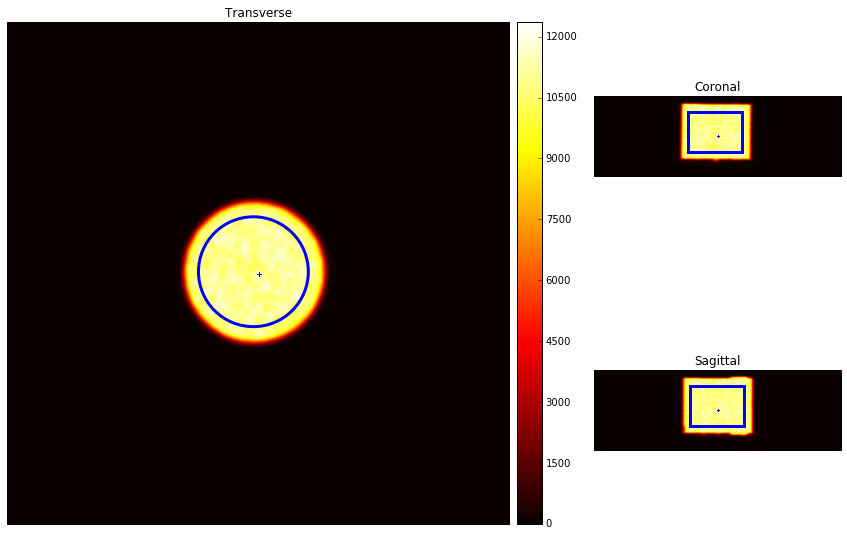

In [86]:
# MAIN INTERFACE #

# Draws circle centers
def redrawCenters():
    line1a[0].set_xdata([xslider.value-1,xslider.value+1])
    line1a[0].set_ydata([zslider.value,zslider.value])
    line1b[0].set_xdata([xslider.value,xslider.value])
    line1b[0].set_ydata([zslider.value-1,zslider.value+1])
    line2a[0].set_xdata([yslider.value-1,yslider.value+1])
    line2a[0].set_ydata([zslider.value,zslider.value])
    line2b[0].set_xdata([yslider.value,yslider.value])
    line2b[0].set_ydata([zslider.value-1,zslider.value+1])
    line3a[0].set_xdata([xslider.value-1,xslider.value+1])
    line3a[0].set_ydata([yslider.value,yslider.value])
    line3b[0].set_xdata([xslider.value,xslider.value])
    line3b[0].set_ydata([yslider.value-1,yslider.value+1])
        
def refreshPlot(b):    
    minv = minslider.value
    maxv = maxslider.value
    if (minv>maxv):
        print "Erreur: min > max"
    else:
        im1.set_data(pixArray[:,yslider.value,:])
        im1.set_clim(vmin=minv, vmax=maxv)
        im2.set_data(pixArray[:,:,xslider.value])
        im2.set_clim(vmin=minv, vmax=maxv)
        im3.set_data(pixArray[zslider.value,:,:])
        im3.set_clim(vmin=minv, vmax=maxv)
    redrawCenters()
    display.clear_output(wait=True)
    display.display(fig)
    results = dispResults(pixArray, arrayDim, roi, ROI_MARGIN, acqDateTime)
  
def onSaveXlsButtonClicked(b):
    saveToXls(results, acq_datetime)


# Plot size
plt.rcParams['figure.figsize'] = (15,9)

# min, max of main image:
_min, _max = np.amin(pixArray), np.amax(pixArray)

# Ipywidgets:
minslider  = FloatSlider(value=_min, min=_min, max=_max, 
                         step=(_max-_min)/100, description='min', width='40%')
maxslider  = FloatSlider(value=_max, min=_min, max=_max*1.5, 
                         step=(_max-_min)/100, description='max', width='40%')

xslider = IntSlider(value=int(arrayDim[2]/2), min=0, max=arrayDim[2]-1, 
                    step=1, description="x",width='40%')
yslider = IntSlider(value=int(arrayDim[1]/2), min=0, max=arrayDim[1]-1, 
                    step=1, description="y",width='40%')
zslider = IntSlider(value=int(arrayDim[0]/2), min=0, max=arrayDim[0]-1, 
                    step=1, description="z",width='40%')

refresh_button = Button(description="Refresh!", width='30%') #, height='100px'
refresh_button.on_click(refreshPlot)


save_button = Button(description="Save to excel file!", width='25%') #, height='100px'
save_button.on_click(onSaveXlsButtonClicked)

items1 = [
    Label(value="Visualization window:", width='90%'),
    minslider,
    maxslider,
    Label(value=". ", width='90%'),
    Label(value="View slices", width='90%'),
    xslider,
    yslider,
    zslider,
    Label(value=". ", width='90%'),
 ]
items2 = [
    refresh_button,
    save_button,
]

box1 = Box(children=items1, layout=box_layout_std)
box2 = Box(children=items2, layout=box_layout_right)
display.display(box1)
display.display(box2)

# Plots the images:
fig = plt.figure()
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,2])
im1 = ax1.imshow(pixArray[:,yslider.value,:], cmap="hot", vmin = _min, vmax = _max)
ax1.set_title('Coronal')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

ax2 = fig.add_subplot(gs[1,2])
im2 = ax2.imshow(pixArray[:,:,xslider.value], cmap="hot", vmin = _min, vmax = _max)
ax2.set_title('Sagittal')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.autoscale(False)

ax3 = fig.add_subplot(gs[:,:-1])
im3 = ax3.imshow(pixArray[zslider.value,:,:], cmap="hot", vmin = _min, vmax = _max)
ax3.set_title('Transverse')
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
ax3.axes.autoscale(False)

roi = findPhantom(pixArray, arrayDim[2], arrayDim[1], arrayDim[0], PHANTOM_THRESHOLD)

try:
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im3, cax=cax3)
    line1a = ax1.axes.plot([xslider.value-1,xslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line1b = ax1.axes.plot([xslider.value,xslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line2a = ax2.axes.plot([yslider.value-1,yslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line2b = ax2.axes.plot([yslider.value,yslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line3a = ax3.axes.plot([xslider.value-1,xslider.value+1], 
                  [yslider.value,yslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line3b = ax3.axes.plot([xslider.value,xslider.value], 
                  [yslider.value-1,yslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    c1 = plt.Circle((roi[0], roi[1]), roi[3]+ROI_MARGIN, fill=False, 
                      color='blue', linewidth=3)
    ax3.axes.add_patch(c1)
    r1 = plt.Rectangle((roi[0]-roi[3]-ROI_MARGIN, roi[2]-roi[4]/2-ROI_MARGIN), 
                      (roi[3]+ROI_MARGIN)*2, roi[4]+2*ROI_MARGIN, fill=False, 
                      color='blue', linewidth=3)
    ax1.axes.add_patch(r1)
    r2 = plt.Rectangle((roi[1]-roi[3]-ROI_MARGIN, roi[2]-roi[4]/2-ROI_MARGIN), 
                      (roi[3]+ROI_MARGIN)*2, roi[4]+2*ROI_MARGIN, fill=False, 
                      color='blue', linewidth=3)
    ax2.axes.add_patch(r2)
except Error: 
    print 'Error!'

results = dispResults(pixArray, arrayDim, roi, ROI_MARGIN, acqDateTime)




# Remarks:

